In [9]:
import numpy as np
import matplotlib.pyplot as plt

data_path = "/Users/joostnachtergaele/mnist_neural/"
test = data_path + "mnist_train.csv"
train_data = np.loadtxt(data_path + "mnist_train.csv", 
                        delimiter=",")
test_data = np.loadtxt(data_path + "mnist_test.csv", 
                       delimiter=",") 
test_data[:10]

array([[7., 0., 0., ..., 0., 0., 0.],
       [2., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [9., 0., 0., ..., 0., 0., 0.],
       [5., 0., 0., ..., 0., 0., 0.],
       [9., 0., 0., ..., 0., 0., 0.]])

Populating the interactive namespace from numpy and matplotlib
up here :  (60000, 784)
(60000, 28, 28)


(60000, 28, 28)

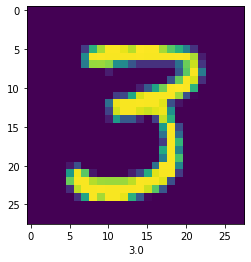

In [79]:
%pylab inline
import random
ran = random.randint(0,len(train_data))
fac = 0.99 / 255
print("up here : ",train_data[:,1:].shape)
train_imgs = np.asfarray(train_data[:, 1:],dtype="float32") * fac + 0.01
test_imgs = np.asfarray(test_data[:, 1:],dtype="float32") * fac + 0.01

train_imgs = train_imgs.reshape(train_imgs.shape[0],28,28)
test_imgs = test_imgs.reshape(test_imgs.shape[0],28,28)
print(train_imgs.shape)
train_labels = np.asfarray(train_data[:, :1],dtype="float32")
test_labels = np.asfarray(test_data[:, :1],dtype="float32")

test = train_imgs[ran].reshape((28,28))
train_labels = train_labels.reshape(train_labels.shape[0])
test_labels.reshape(test_labels.shape[0])
imshow(test)
xlabel(train_labels[ran])
train_imgs.reshape(train_imgs.shape[0],28,28).shape

In [239]:
import torch
from torch import nn
import torch.nn.functional as F
from tqdm import trange
class the_net(torch.nn.Module):
    def __init__(self):
        super(the_net,self).__init__()
        self.l1 = nn.Linear(784,128,bias=False)
        #self.l2 = nn.Linear(128,10,bias=True)
        #self.l3 = nn.Linear(32,10,bias=False)
        self.l2 = nn.BatchNorm1d(128)
        self.l3 = nn.Linear(128,10,bias=False)
        self.soft_max = nn.LogSoftmax(dim=1)
    def forward(self,x):
        x = F.relu(self.l1(x))
        #x = F.relu(self.l2(x))
        x = self.l2(x)
        #x = self.l3(x)
        x = self.l3(x)
        x = self.soft_max(x)
        return x
        

loss 0.22 accuracy 0.96: 100%|██████████| 8000/8000 [00:49<00:00, 160.67it/s]


the_net(
  (l1): Linear(in_features=784, out_features=128, bias=False)
  (l2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l3): Linear(in_features=128, out_features=10, bias=False)
  (soft_max): LogSoftmax(dim=1)
)

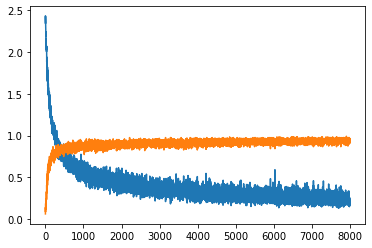

In [261]:
model = the_net()
loss_function = nn.NLLLoss(reduction="none")
# 
#loss_function = nn.CrossEntropyLoss(reduce=None)
optim = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0)
bs = 128
losses, accuracies = [], []

for i in (t := trange(8000)):
    samp = np.random.randint(0,train_imgs.shape[0],size=(bs))
    X = torch.tensor(train_imgs[samp].reshape((-1,28*28))).float()
    Y = torch.tensor(train_labels[samp]).long()
    model.zero_grad()
    out = model(X)
    cat = torch.argmax(out,dim=1)
    accuracy = (cat ==Y).float().mean()
    loss = loss_function(out,Y)
    loss = loss.mean()
    loss.backward()
    optim.step()
    loss,accuracy = loss.item(), accuracy.item()
    losses.append(loss)
    accuracies.append(accuracy)
    t.set_description("loss %.2f accuracy %.2f"%(loss,accuracy))
plot(losses)
plot(accuracies)
model.eval()


8105
(784,)
the predicted value:  8


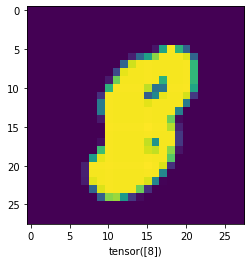

In [288]:
l1 = model.l1.weight.detach().numpy().T
l2 = model.l2.weight.detach().numpy().T
l3 = model.l3.weight.detach().numpy().T
# numpy forward pass
def forward(x):
    x = x.dot(l1)
    #print("the first x :",x)
    x = x *l2  
    #print("the second x: ",x)
    x = x.dot(l3)
    return x

#test_img = torch.tensor(test_imgs[1].reshape((-1,28*28))).float()

the_ind = random.randint(0,test_imgs.shape[0])
print(the_ind)
test_img = test_imgs[1].reshape((28*28))
test_label = torch.tensor(test_labels[the_ind]).long()
xlabel(test_label)
imshow(test_imgs[the_ind])
print(test_img.shape)

the_img = test_imgs[the_ind].reshape((28*28))
out = forward(the_img)
print("the predicted value: ",out.argmax())


In [237]:
out

array([-0.22941488,  0.5480566 ,  0.2642619 ,  0.27409452, -0.3670823 ,
       -0.23378728,  0.01621557, -0.25868616,  0.59343785, -0.01916615],
      dtype=float32)